In [ ]:
from google.colab import files
uploaded = files.upload()   # chọn file từ máy

Saving afc.jpg to afc.jpg


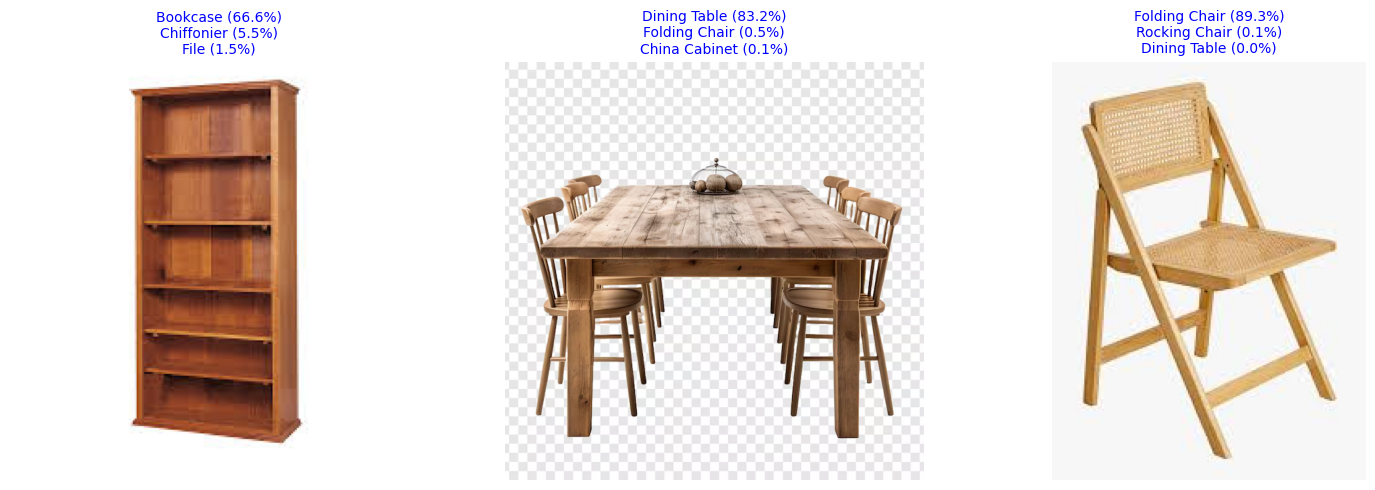

In [ ]:
import torch
from torchvision.models import resnet152, ResNet152_Weights
from torchvision import transforms
from PIL import Image
import urllib.request
import matplotlib.pyplot as plt
import os
import json

# --- Danh sách ảnh local---
IMAGE_FILES = [
    "bc.jpg",
    "adt1.jpg",
    "afc.jpg"
]

# --- Tải ResNet152 pretrained ---
weights = ResNet152_Weights.DEFAULT
model = resnet152(weights=weights)
model.eval()

# --- Tải nhãn ImageNet ---
LABEL_URLS = [
    "https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json"
]

class_labels = None
for url in LABEL_URLS:
    try:
        with urllib.request.urlopen(url) as response:
            data = json.load(response)
        sorted_labels = sorted(data.items(), key=lambda item: int(item[0]))
        class_labels = [item[1][1] for item in sorted_labels]
        break
    except:
        continue
if class_labels is None:
    raise RuntimeError("Không tải được nhãn ImageNet!")

# --- Tiền xử lý ảnh và tạo batch ---
transform = weights.transforms()
image_tensors = []
original_images = []
found_files = []

for file_name in IMAGE_FILES:
    if os.path.exists(file_name):
        img = Image.open(file_name).convert("RGB")
        image_tensors.append(transform(img))
        original_images.append(img)
        found_files.append(file_name)
    else:
        print(f"Không tìm thấy file '{file_name}', bỏ qua.")

if not image_tensors:
    raise RuntimeError("Không có ảnh nào hợp lệ!")

img_batch = torch.stack(image_tensors)

# --- Dự đoán batch và lấy top-3 ---
with torch.no_grad():
    out = model(img_batch)
    probs = torch.nn.functional.softmax(out, dim=1)
    top_p, top_idx = torch.topk(probs, k=3, dim=1)  # top-3

# --- Hiển thị kết quả ---
fig, axes = plt.subplots(1, len(original_images), figsize=(15, 5))
if len(original_images) == 1:
    axes = [axes]

for i in range(len(original_images)):
    ax = axes[i]
    ax.imshow(original_images[i])
    ax.axis("off")

    # Lấy top-3 nhãn
    top3_labels = [class_labels[idx] for idx in top_idx[i]]
    top3_conf = [p.item()*100 for p in top_p[i]]
    title = "\n".join([f"{lbl.replace('_',' ').title()} ({conf:.1f}%)"
                       for lbl, conf in zip(top3_labels, top3_conf)])
    ax.set_title(title, fontsize=10, color='blue')

plt.tight_layout()
plt.show()
